# Adapted from [Dive into Deep Learning](https://d2l.ai/index.html), Chapter 7, Section 6. The authors are prominent Amazon data scientists, so they work primarily with the [MXNet](https://mxnet.apache.org/versions/1.7.0/) framework rather than [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/). As such, this assignment will rely on MXNet as well. 

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

## If running this notebook in Colab, make sure to navigate to Runtime > Change runtime type, select GPU in the Hardward accelerator drop-down menu, and click Save *before* running the following code cell! Otherwise, `mxnet-cu101` won't install.

In [8]:
!pip install d2l==0.15.1
!pip install mxnet

     |████████████████████████████████| 34.9 MB 16.4 MB/s eta 0:00:01   |██▎                             | 2.5 MB 2.3 MB/s eta 0:00:15


# Residual Networks (ResNets)
:label:`sec_resnet`

As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.


## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let us assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance, 
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse. 
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the "truth" function ($f^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can 
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that He et al. considered when working on very deep computer vision models :cite:`He.Zhang.Ren.ea.2016`. 
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should 
more easily
contain the identity function as one of its elements. 
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks.



## Residual Blocks

Let us focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that the desired underlying mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as the input to the activation function on the top.
On the left of :numref:`fig_residual_block`,
the portion within the dotted-line box 
must directly learn the mapping $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping is easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully-connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure in :numref:`fig_residual_block` illustrates the  *residual block* of ResNet,
where the solid line carrying the layer input 
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can 
forward propagate faster through the residual connections across layers.

![A regular block (left) and a residual block (right).](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/residual-block.svg?raw=1)
:label:`fig_residual_block`


ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. 

The code below generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this:

![ResNet block with and without $1 \times 1$ convolution.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/resnet-block.svg?raw=1)
:label:`fig_resnet_block`


### Exercise: Implement the figures above as the `Residual` class. 
Notes: 
1. The d2l module allows us to use utility functions developed for the Dive into Deep Learning book.
2. MXNet's np and npx modules allow for Numpy-compatible coding, which MXNet's basic ndarray module doesn't, as [this](https://github.com/apache/incubator-mxnet/issues/14253) post illustrates. You might also find [this](https://stackoverflow.com/questions/58933738/mxnet-import-nd-or-np-to-use-arrays) Stack Overflow query helpful.
3. [Gluon](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/index.html) is to MXNet as Keras is to TensorFlow.
4. You might find the following functions useful: [`mxnet.gluon.nn.Conv2D()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Conv2D), [`mxnet.gluon.nn.BatchNorm()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.BatchNorm), [`mxnet.gluon.nn.Activation()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Activation), [`npx.relu()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/ndarray/op/index.html#mxnet.ndarray.op.relu).


In [23]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

class Residual(nn.Block):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        ### START CODE HERE ###
        super().__init__(**kwargs)
        # Convolutional layer with num_channels output channels, kernel size of 3, 
        # and padding of 1. Pass in the strides used to instantiate the class.
        self.conv1 = nn.Conv2D(channels=num_channels, kernel_size=3, strides=strides, padding=1)
        # Convolutional layer like the first, but with the default stride of 1
        self.conv2 = nn.Conv2D(channels=num_channels, kernel_size=3, padding=1)
        # If we're using a 1 x 1 convolution on the residual branch...
        if use_1x1conv:
            # Convolutional layer with num_channels output channels and kernel size of 1. 
            # Pass in the strides used to instantiate the class.
            self.conv3 = nn.Conv2D(channels=num_channels, kernel_size=1, strides=strides)
        else:
            # DON'T replace the None on the next line!
            self.conv3 = None
        # Batch normalization. Use the default parameters. 
        self.bn1 = nn.BatchNorm()
        # Batch normalization. Use the default parameters.
        self.bn2 = nn.BatchNorm()
        ### END CODE HERE ###

    def forward(self, X):
        ### START CODE HERE ###
        # Pass the input layer through the first convolutional layer
        Y = self.conv1(X)
        # First batch normalization layer
        Y = self.bn1(Y)
        # ReLU activation
        Y = npx.relu(Y)
        # Second convolutional layer
        Y = self.conv2(Y)
        # Second batch normalization layer 
        Y = self.bn2(Y)
        # If the third convolutional layer exists, pass the input layer through it
        if self.conv3:
            X = self.conv3(X)
        # Add the two branches together, then apply a ReLU activation to the summed layer
        return npx.relu(X + Y)
        ### END CODE HERE ###

Now let us look at a situation where the input and output are of the same shape.

In [24]:
blk = Residual(3)
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk(X).shape

(4, 3, 6, 6)

We also have the option to halve the output height and width while increasing the number of output channels.


In [25]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

(4, 6, 3, 3)

## ResNet Model

### Exercise: Instantiate the ResNet model with Gluon's [`nn.Sequential()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Sequential) API, then add to the model as follows: 

The first two layers of ResNet are the same as those of GoogLeNet: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

You may find Gluon's [`nn.Activation()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Activation) and [`nn.MaxPool2D()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.MaxPool2D) useful.


In [96]:
### START CODE HERE ###
# Instantiate the model
net = nn.Sequential()
# Start adding to the model
net.add(# Convolutional layer
        nn.Conv2D(channels=64, kernel_size=7, strides=2, padding=3),
        # Batch normalization
        nn.BatchNorm(), 
        # ReLU activation
        nn.Activation("relu"),
        # Max pooling
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
### END CODE HERE ###

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. 
The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.


### Exercise: Build a function which wraps around a `Residual` block as defined earlier. Make use of the `nn.Sequential()` API and the `add()` method for MXNet models. Give the first block all possible default arguments.

In [101]:
def resnet_block(num_channels, num_residuals, first_block=False):
    ### START CODE HERE ###
    # Initialize the ResNet block
    blocks = nn.Sequential()
    # Iterate through the residual sub-blocks
    for i in range(num_residuals):
        # If this is the first sub-block but NOT the first ResNet block of the whole model...
        if i == 0 and not first_block:
            # Add a residual sub-block with num_channels output channels, 
            # 1 x 1 convolutions, and a stride of 2
            blk = Residual(num_channels, use_1x1conv=True, strides=2)
            blocks.add(blk)
        else:
            # If not, add a residual sub-block with num_channels output channels 
            # and otherwise default arguments
            blocks.add(Residual(num_channels))
    # Return the ResNet block
    return blocks
    ### END CODE HERE ###

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module.


In [102]:
list(net)

[Conv2D(-1 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
 BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=-1),
 Activation(relu),
 MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)]

### Exercise: Add 4 ResNet blocks to the model, with 64, 128, 256, and 512 respective output channels, and each with 2 sub-blocks. Don't forget about the `first_block` parameter!

In [103]:
net.add(resnet_block(64, 2, first_block=True))

In [104]:
net.add(resnet_block(128, 2))
net.add(resnet_block(256, 2))
net.add(resnet_block(512, 2))

In [105]:
list(net)

[Conv2D(-1 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
 BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=-1),
 Activation(relu),
 MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW),
 Sequential(
   (0): Residual(
     (conv1): Conv2D(-1 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (conv2): Conv2D(-1 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=-1)
     (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=-1)
   )
   (1): Residual(
     (conv1): Conv2D(-1 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (conv2): Conv2D(-1 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_

### Exercise: Finally, just like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output.


In [106]:
net.add(
    nn.GlobalAvgPool2D(),
    nn.Dense(10)
)

There are 4 convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully-connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](http://d2l.ai/_images/resnet18.svg)
:label:`fig_resnet18`


### Exercise: Before training ResNet, let us observe how the input shape changes across different modules in ResNet. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features. Print the output shape of each module in the model.

In [107]:
# Initialize the input with a random array
X = np.random.uniform(size=(1, 1, 224, 224))
# Initialize the model
net.initialize()
### START CODE HERE ###
# Loop over the layers in the model
for layer in net:
    # Apply the current layer to its input or the output of the previous layer
    X = layer(X)
    # Print the current layer's name and the output's shape
    print(layer.name, 'output shape:\t', X.shape)
### END CODE HERE ###

conv221 output shape:	 (1, 64, 112, 112)
batchnorm203 output shape:	 (1, 64, 112, 112)
relu11 output shape:	 (1, 64, 112, 112)
pool15 output shape:	 (1, 64, 56, 56)
sequential13 output shape:	 (1, 64, 56, 56)
sequential14 output shape:	 (1, 128, 28, 28)
sequential15 output shape:	 (1, 256, 14, 14)
sequential16 output shape:	 (1, 512, 7, 7)
pool16 output shape:	 (1, 512, 1, 1)
dense7 output shape:	 (1, 10)


### Expected Output: 
```
conv5 output shape:	 (1, 64, 112, 112)
batchnorm4 output shape:	 (1, 64, 112, 112)
relu0 output shape:	 (1, 64, 112, 112)
pool0 output shape:	 (1, 64, 56, 56)
sequential1 output shape:	 (1, 64, 56, 56)
sequential2 output shape:	 (1, 128, 28, 28)
sequential3 output shape:	 (1, 256, 14, 14)
sequential4 output shape:	 (1, 512, 7, 7)
pool1 output shape:	 (1, 512, 1, 1)
dense0 output shape:	 (1, 10)
```

### Exercise: For a more detailed look, use the model's [`summary()`](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/block.html#mxnet.gluon.Block.summary) method

In [114]:
### START CODE HERE ###
# Initialize the input, consisting of 1 example, 1 output channel, and a pixel height and width of 224
X = np.random.uniform(size=(1, 1, 224, 224))
# Reinitialize the model
net.initialize(force_reinit=True)
# Summarize the model
net.summary(X)
### END CODE HERE ###

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 1, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            3200
         BatchNorm-2                           (1, 64, 112, 112)             256
        Activation-3                           (1, 64, 112, 112)               0
         MaxPool2D-4                             (1, 64, 56, 56)               0
            Conv2D-5                             (1, 64, 56, 56)           36928
         BatchNorm-6                             (1, 64, 56, 56)             256
            Conv2D-7                             (1, 64, 56, 56)           36928
         BatchNorm-8                             (1, 64, 56, 56)             256
          Residual-9                             (1, 64, 56, 56)               0
           Conv2D-10        

### Expected Output: 
```
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
================================================================================
               Input                            (1, 1, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            3200
         BatchNorm-2                           (1, 64, 112, 112)             256
        Activation-3                           (1, 64, 112, 112)               0
         MaxPool2D-4                             (1, 64, 56, 56)               0
            Conv2D-5                             (1, 64, 56, 56)           36928
         BatchNorm-6                             (1, 64, 56, 56)             256
            Conv2D-7                             (1, 64, 56, 56)           36928
         BatchNorm-8                             (1, 64, 56, 56)             256
          Residual-9                             (1, 64, 56, 56)               0
           Conv2D-10                             (1, 64, 56, 56)           36928
        BatchNorm-11                             (1, 64, 56, 56)             256
           Conv2D-12                             (1, 64, 56, 56)           36928
        BatchNorm-13                             (1, 64, 56, 56)             256
         Residual-14                             (1, 64, 56, 56)               0
           Conv2D-15                            (1, 128, 28, 28)           73856
        BatchNorm-16                            (1, 128, 28, 28)             512
           Conv2D-17                            (1, 128, 28, 28)          147584
        BatchNorm-18                            (1, 128, 28, 28)             512
           Conv2D-19                            (1, 128, 28, 28)            8320
         Residual-20                            (1, 128, 28, 28)               0
           Conv2D-21                            (1, 128, 28, 28)          147584
        BatchNorm-22                            (1, 128, 28, 28)             512
           Conv2D-23                            (1, 128, 28, 28)          147584
        BatchNorm-24                            (1, 128, 28, 28)             512
         Residual-25                            (1, 128, 28, 28)               0
           Conv2D-26                            (1, 256, 14, 14)          295168
        BatchNorm-27                            (1, 256, 14, 14)            1024
           Conv2D-28                            (1, 256, 14, 14)          590080
        BatchNorm-29                            (1, 256, 14, 14)            1024
           Conv2D-30                            (1, 256, 14, 14)           33024
         Residual-31                            (1, 256, 14, 14)               0
           Conv2D-32                            (1, 256, 14, 14)          590080
        BatchNorm-33                            (1, 256, 14, 14)            1024
           Conv2D-34                            (1, 256, 14, 14)          590080
        BatchNorm-35                            (1, 256, 14, 14)            1024
         Residual-36                            (1, 256, 14, 14)               0
           Conv2D-37                              (1, 512, 7, 7)         1180160
        BatchNorm-38                              (1, 512, 7, 7)            2048
           Conv2D-39                              (1, 512, 7, 7)         2359808
        BatchNorm-40                              (1, 512, 7, 7)            2048
           Conv2D-41                              (1, 512, 7, 7)          131584
         Residual-42                              (1, 512, 7, 7)               0
           Conv2D-43                              (1, 512, 7, 7)         2359808
        BatchNorm-44                              (1, 512, 7, 7)            2048
           Conv2D-45                              (1, 512, 7, 7)         2359808
        BatchNorm-46                              (1, 512, 7, 7)            2048
         Residual-47                              (1, 512, 7, 7)               0
  GlobalAvgPool2D-48                              (1, 512, 1, 1)               0
            Dense-49                                     (1, 10)            5130
================================================================================
Parameters in forward computation graph, duplicate included
   Total params: 11186186
   Trainable params: 11178378
   Non-trainable params: 7808
Shared params in forward computation graph: 0
Unique parameters in model: 11186186
--------------------------------------------------------------------------------
```

## Training

### Train the ResNet on the Fashion-MNIST dataset. Notes: 
1. This process takes approximately 8 minutes when running a Colab on a single GPU 
2. The next cell uses utility functions developed for the Dive into Deep Learning (d2l) book


loss 0.116, train acc 0.956, test acc 0.928
29.5 examples/sec on cpu(0)


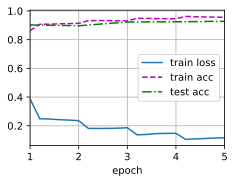

In [117]:
lr, num_epochs, batch_size = 0.03, 5, 16
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* Nested function classes are desirable. Learning an additional layer in deep neural networks as an identity function (though this is an extreme case) should be made easy.
* The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.
* We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers.
* ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.
